<h1 style="background-color: Teal; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
Merging the datasets
</h1>

In [1]:
%pip install scikit-fuzzy

   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/920.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/920.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/920.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/920.8 kB ? eta -:--:--
   --------------------- ---------------- 524.3/920.8 kB 254.3 kB/s eta 0:00:02
   --------------------- ---------------- 524.3/920.8 kB 254.3 kB/s eta 0:00:02
   --------------------- ---------------- 524.3/920.8 kB 254.3 kB/s eta 0:00:02
   --------------------- ---------------- 


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#important libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples 
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
import skfuzzy as fuzz
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors


%config InlineBackend.figure_format = 'retina' 

# Setting seaborn style
sns.set()

In [3]:
# Helper function from previous labs
def get_ss(df, features):
    """Calculate total sum of squares (SST)"""
    return np.sum(df[features].var() * (df[features].count() - 1))

def get_ssw(df, features, labels):
    """Calculate within-cluster sum of squares (SSW)"""
    df_temp = df[features].copy()
    df_temp['labels'] = labels
    return df_temp.groupby('labels')[features].apply(lambda x: get_ss(x, features)).sum()

def get_rsq(df, features, labels):
    """Calculate R² for clustering quality"""
    sst = get_ss(df, features)
    ssw = get_ssw(df, features, labels)
    return 1 - (ssw / sst)

In [4]:
# Load the datasets after EDA
df_flights_eda = pd.read_csv('DM_AIAI_FlightsDB_after_eda.csv') 
df_costumers_eda = pd.read_csv('DM_AIAI_CustomersDB_after_eda.csv')

In [5]:
df_flights_eda.head()

,Loyalty#,NumFlights,NumFlightsWithCompanions,PointsAccumulated,PointsRedeemed,Recency_Months,PointsRedeemRatio,FlightsWithCompanionsRatio
0,100018,225,45,53014.30,20562.8,0.0,0.387873,0.200000
1,100102,245,55,33903.96,18760.6,0.0,0.553345,0.224490
2,100140,211,51,43192.58,4896.0,1.0,0.113353,0.241706
3,100214,108,17,36453.77,12908.6,0.0,0.354109,0.157407
4,100272,181,50,42953.25,10891.4,1.0,0.253564,0.276243


In [6]:
df_costumers_eda.head()

,Loyalty#,Province or State,City,Latitude,Longitude,Postal code,Education,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,Income_Class,CustomerTenure,Active_Client
0,480934,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,Bachelor,70146.0,Married,Star,2019-02-15,2021-12-31,3839.14,Standard,Non-Zero Income,1050,Active
1,549612,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,College,0.0,Divorced,Star,2019-03-09,2021-12-31,3839.61,Standard,Zero Income,1028,Active
2,429460,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,College,0.0,Single,Star,2017-07-14,2021-01-08,3839.75,Standard,Zero Income,1274,Inactive
3,608370,Ontario,Toronto,43.653225,-79.383186,P1W 1K4,College,0.0,Single,Star,2016-02-17,2021-12-31,3839.75,Standard,Zero Income,2144,Active
4,530508,Quebec,Hull,45.428730,-75.713364,J8Y 3Z5,Bachelor,97832.0,Married,Star,2017-10-25,2021-12-31,3842.79,2021 Promotion,Non-Zero Income,1528,Active


In [7]:
#merging both datasets
merged_df = df_flights_eda.merge(df_costumers_eda, on="Loyalty#", how = "inner" ) 

In [8]:
merged_df.head()

,Loyalty#,NumFlights,NumFlightsWithCompanions,PointsAccumulated,PointsRedeemed,Recency_Months,PointsRedeemRatio,FlightsWithCompanionsRatio,Province or State,City,...,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,Income_Class,CustomerTenure,Active_Client
0,100018,225,45,53014.30,20562.8,0.0,0.387873,0.200000,Alberta,Edmonton,...,82877.0,Married,Aurora,2019-08-09,2021-12-31,7919.20,Standard,Non-Zero Income,875,Active
1,100102,245,55,33903.96,18760.6,0.0,0.553345,0.224490,Ontario,Toronto,...,0.0,Single,Nova,2016-03-09,2021-12-31,2887.74,Standard,Zero Income,2123,Active
2,100140,211,51,43192.58,4896.0,1.0,0.113353,0.241706,British Columbia,Dawson Creek,...,0.0,Divorced,Nova,2019-07-30,2021-12-31,2838.07,Standard,Zero Income,885,Active
3,100214,108,17,36453.77,12908.6,0.0,0.354109,0.157407,British Columbia,Vancouver,...,42837.0,Married,Star,2018-08-06,2021-12-31,4170.57,Standard,Non-Zero Income,1243,Active
4,100272,181,50,42953.25,10891.4,1.0,0.253564,0.276243,Ontario,Toronto,...,80979.0,Divorced,Star,2017-01-09,2021-12-31,6622.05,Standard,Non-Zero Income,1817,Active


In [9]:
merged_df.head()

,Loyalty#,NumFlights,NumFlightsWithCompanions,PointsAccumulated,PointsRedeemed,Recency_Months,PointsRedeemRatio,FlightsWithCompanionsRatio,Province or State,City,...,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,Income_Class,CustomerTenure,Active_Client
0,100018,225,45,53014.30,20562.8,0.0,0.387873,0.200000,Alberta,Edmonton,...,82877.0,Married,Aurora,2019-08-09,2021-12-31,7919.20,Standard,Non-Zero Income,875,Active
1,100102,245,55,33903.96,18760.6,0.0,0.553345,0.224490,Ontario,Toronto,...,0.0,Single,Nova,2016-03-09,2021-12-31,2887.74,Standard,Zero Income,2123,Active
2,100140,211,51,43192.58,4896.0,1.0,0.113353,0.241706,British Columbia,Dawson Creek,...,0.0,Divorced,Nova,2019-07-30,2021-12-31,2838.07,Standard,Zero Income,885,Active
3,100214,108,17,36453.77,12908.6,0.0,0.354109,0.157407,British Columbia,Vancouver,...,42837.0,Married,Star,2018-08-06,2021-12-31,4170.57,Standard,Non-Zero Income,1243,Active
4,100272,181,50,42953.25,10891.4,1.0,0.253564,0.276243,Ontario,Toronto,...,80979.0,Divorced,Star,2017-01-09,2021-12-31,6622.05,Standard,Non-Zero Income,1817,Active


In [10]:
merged_df["EnrollmentDateOpening"] = pd.to_datetime(merged_df["EnrollmentDateOpening"])
merged_df["CancellationDate"] = pd.to_datetime(merged_df["CancellationDate"])
merged_df["Enroll_Year"] = merged_df["EnrollmentDateOpening"].dt.year
merged_df["Enroll_Month"] = merged_df["EnrollmentDateOpening"].dt.month

In [11]:
merged_df.set_index("Loyalty#", inplace=True)

In [12]:
merged_df.dtypes

NumFlights                             int64
NumFlightsWithCompanions               int64
PointsAccumulated                    float64
PointsRedeemed                       float64
Recency_Months                       float64
PointsRedeemRatio                    float64
FlightsWithCompanionsRatio           float64
Province or State                     object
City                                  object
Latitude                             float64
Longitude                            float64
Postal code                           object
Education                             object
Income                               float64
Marital Status                        object
LoyaltyStatus                         object
EnrollmentDateOpening         datetime64[ns]
CancellationDate              datetime64[ns]
Customer Lifetime Value              float64
EnrollmentType                        object
Income_Class                          object
CustomerTenure                         int64
Active_Cli

In [13]:
#Splitting diferent features into categorical and numerical
metric_features = [
    'NumFlights',
    'PointsAccumulated',
    'PointsRedeemed',
    'Recency_Months',
    'Customer Lifetime Value',
    'CustomerTenure'
]
non_metric_features = [
    'Education',
    'Marital Status',
    'LoyaltyStatus',
    'Income_Class',
    'Active_Client'
]
unused_features = [i for i in merged_df.columns if i not in (metric_features+non_metric_features) ]

In [14]:
print('metric_features:', metric_features)
print('non_metric_features:', non_metric_features)
print('unused_features:', unused_features)

metric_features: ['NumFlights', 'PointsAccumulated', 'PointsRedeemed', 'Recency_Months', 'Customer Lifetime Value', 'CustomerTenure']
non_metric_features: ['Education', 'Marital Status', 'LoyaltyStatus', 'Income_Class', 'Active_Client']
unused_features: ['NumFlightsWithCompanions', 'PointsRedeemRatio', 'FlightsWithCompanionsRatio', 'Province or State', 'City', 'Latitude', 'Longitude', 'Postal code', 'Income', 'EnrollmentDateOpening', 'CancellationDate', 'EnrollmentType', 'Enroll_Year', 'Enroll_Month']


In [15]:
X_cat = OneHotEncoder(sparse_output=False).fit_transform(merged_df[non_metric_features])
X_num = StandardScaler().fit_transform(merged_df[metric_features])

Now that we finished merging our datasets, we are ready to start testing the diferent types of clustering methods, in this project we will test, Agglomerative, K-means and Fuzzy Clustering.

<h1 style="background-color: Teal; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
Clustering
</h1>

### Agglomerative Clustering

In [16]:
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        #create the hierarchical clustering model
        cluster = AgglomerativeClustering(linkage=link_method, metric=dist, n_clusters=i)
        
        #get cluster labels
        hclabels = cluster.fit_predict(df[feats])
        
        
        # append the R2 of the given cluster solution
        r2.append(get_rsq(X_df, feats, hclabels))

    return np.array(r2)

X_df = pd.DataFrame(X_num, columns=metric_features, index=merged_df.index)

results = []
for link in hc_methods:
    r2 = get_r2_hc(
        df=X_df, 
        link_method=link, 
        max_nclus=max_nclus, 
        min_nclus=1, 
        dist="euclidean")
    results.append(r2)

r2_hc = np.vstack(results) 

r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)

r2_hc_methods



,ward,complete,average,single
1,0.000000,0.000000,0.000000,0.000000
2,0.318694,0.039018,0.143121,0.000867
3,0.452539,0.180557,0.189366,0.002814
4,0.551501,0.249208,0.189868,0.003119
5,0.608709,0.578874,0.191497,0.003927
6,0.638467,0.584357,0.193142,0.003968
7,0.663177,0.594601,0.198003,0.004427
8,0.685010,0.613823,0.205593,0.004447
9,0.705923,0.614984,0.206026,0.004760
10,0.723171,0.615635,0.559928,0.009247


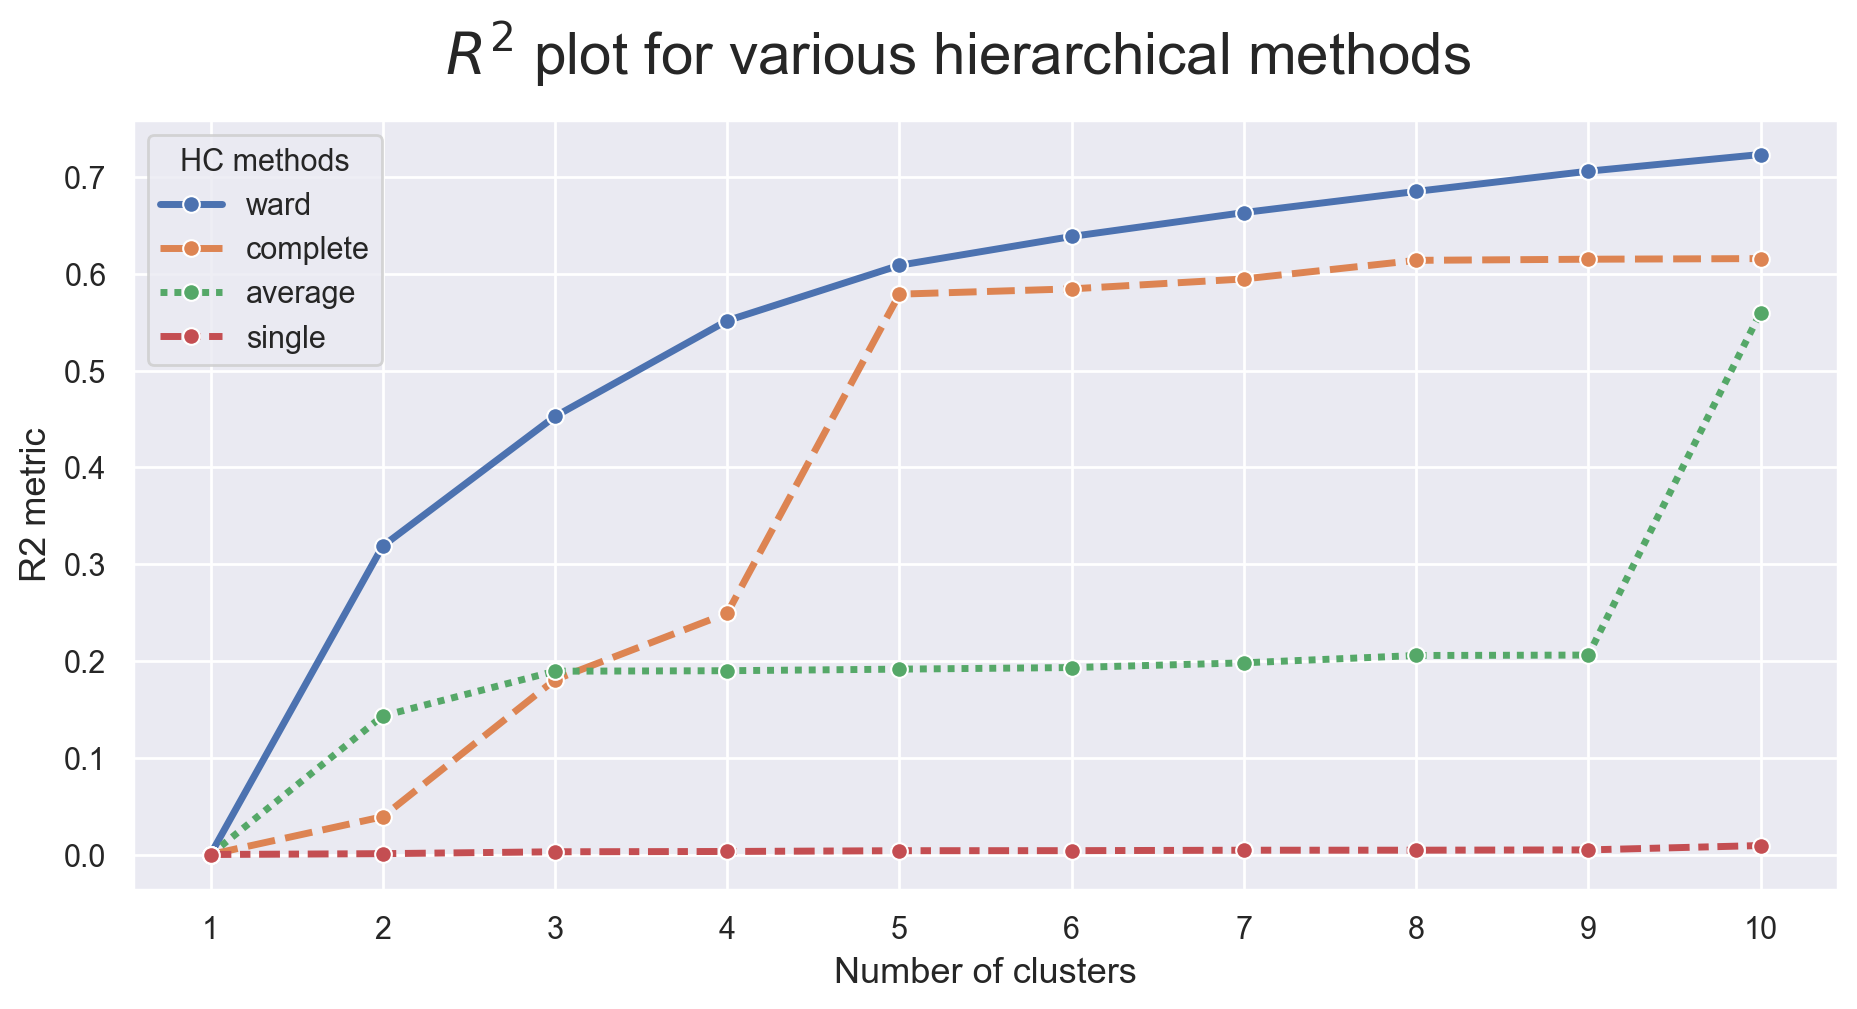

In [17]:
sns.set()

# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)

plt.show()

In [18]:
# Compute the linkage matrix
linkage_matrix= linkage(X_num, method="ward")  
distance = 'euclidean'

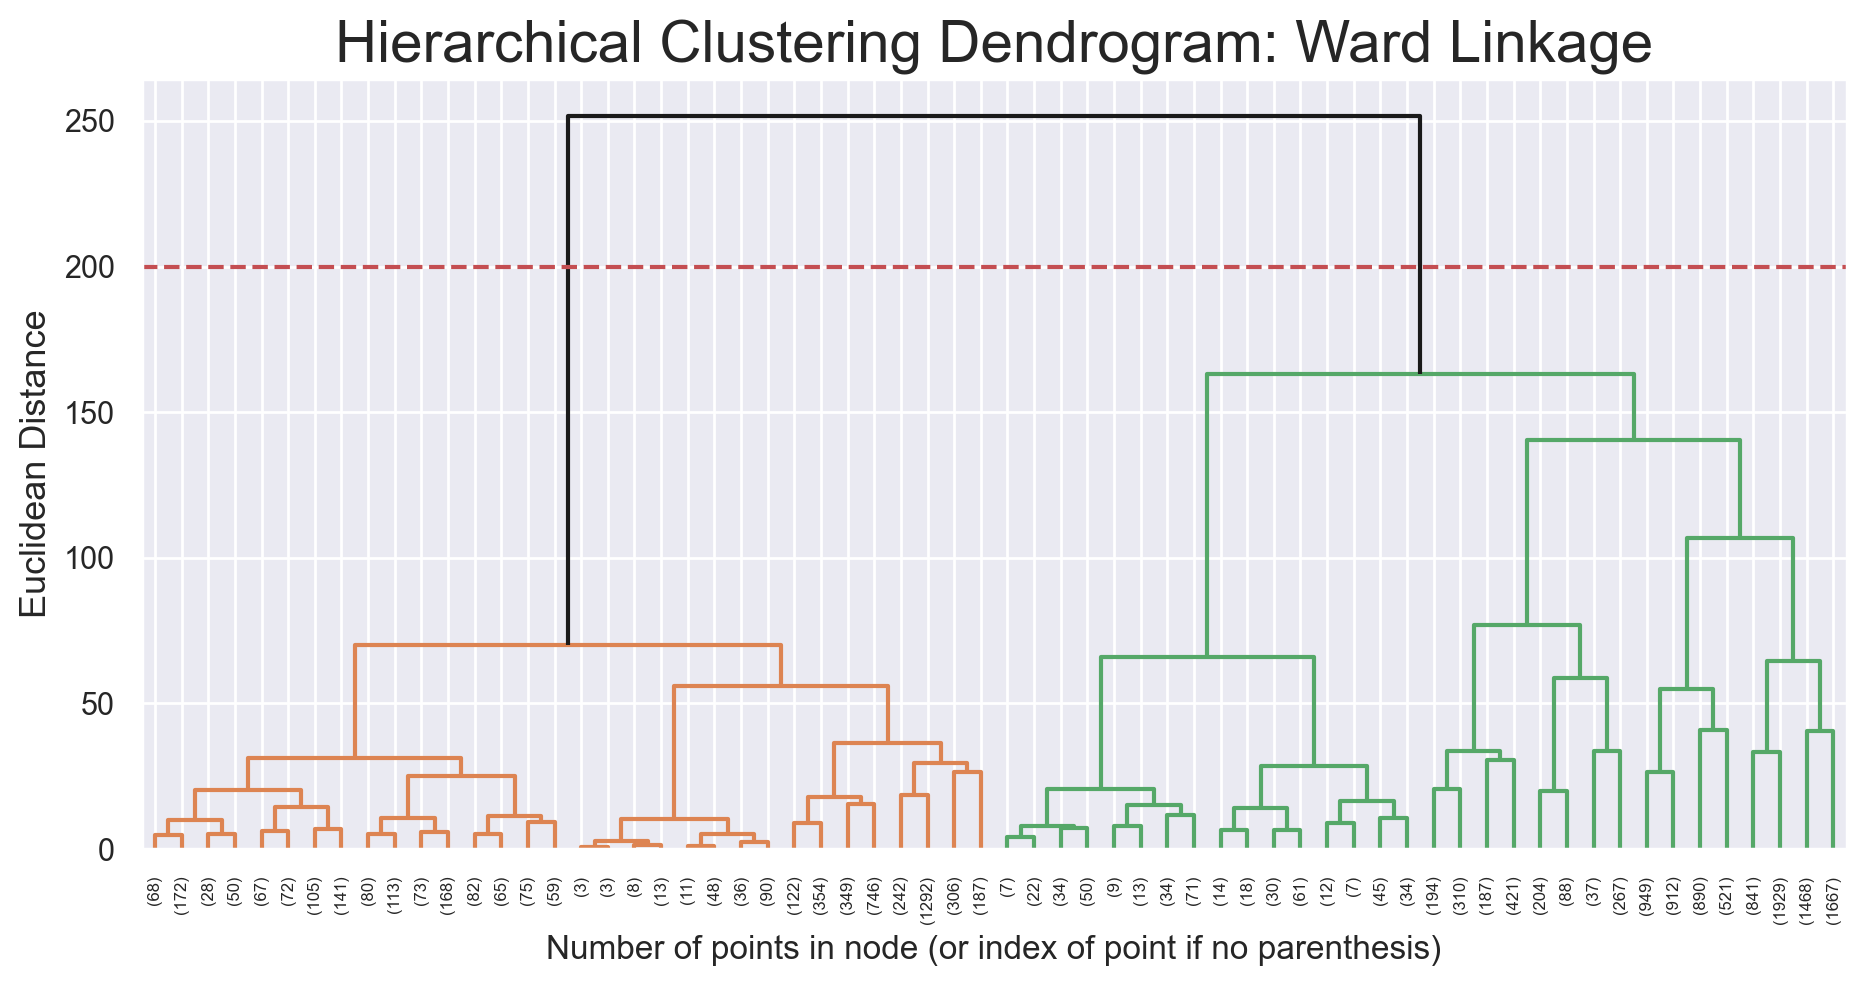

In [19]:

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
Y_THRESHOLD = 200
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=Y_THRESHOLD, above_threshold_color='k')
    # You can play with 'truncate_mode' and 'p' define what level the dendrogram shows
    # above_threshold_color='k' forces black color for the lines above the threshold)
plt.hlines(Y_THRESHOLD, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

Determination of the Optimal Number of Clusters Using a Dendrogram:

The hierarchical clustering structure was examined through a dendrogram obtained using Ward’s linkage method applied to standardized metric features. The dendrogram illustrates the successive merging of observations based on the increase in within-cluster variance.

A clear and substantial increase in linkage distance is observed at the final merge, where the distance rises sharply from approximately 160 to 250. This represents the transition from two clusters to a single cluster and indicates that the two remaining groups are highly dissimilar. According to standard hierarchical clustering criteria, this pronounced jump suggests that a **two clusters** solution provides the strongest overall separation and constitutes the most robust partition of the data.


However, an earlier but still significant increase in linkage distance can be identified at an intermediate level, approximately between distances of 130 and 160. Cutting the dendrogram at this level yields **three clusters**, which remain well separated and internally coherent.

In summary:
- **Two clusters** offer the simplest and most robust partition, maximizing separation between groups.
- **Three clusters** provide a more granular and informative segmentation while maintaining meaningful inter-cluster distances.

Therefore, while two clusters represent the primary choice based on the largest distance jump, **three clusters also constitute a valid and justifiable alternative**, particularly when a more detailed cluster interpretation is desired. Let's test with 2 and 3 clusters and compare the results.


In [20]:
#2 cluster solution
hc2 = AgglomerativeClustering(
   n_clusters=2,
    linkage='ward',
    metric='euclidean'
)

hc2_labels = hc2.fit_predict(X_num)

In [21]:
# Characterizing the 2 clusters
df_concat = pd.concat([merged_df[metric_features], 
                       pd.Series(hc2_labels, 
                                 name='labels', 
                                 index=merged_df.index)], 
                    axis=1)

df_concat.groupby('labels').mean()

,NumFlights,PointsAccumulated,PointsRedeemed,Recency_Months,Customer Lifetime Value,CustomerTenure
labels,,,,,,
0,180.922616,36835.122001,11193.875868,0.734885,8670.750377,1407.580910
1,46.221691,9285.554788,2694.583321,0.009564,6501.497636,370.201798


In [22]:
#3 cluster solution
hc3_clust = AgglomerativeClustering(
    n_clusters=3, 
    linkage='ward', 
    metric='euclidean'
    )

hc3_labels = hc3_clust.fit_predict(X_num)

In [23]:
# Characterizing the 3 clusters
df_concat = pd.concat([merged_df[metric_features], 
                       pd.Series(hc3_labels, 
                                 name='labels', 
                                 index=merged_df.index)], 
                    axis=1)

df_concat.groupby('labels').mean()

,NumFlights,PointsAccumulated,PointsRedeemed,Recency_Months,Customer Lifetime Value,CustomerTenure
labels,,,,,,
0,183.556638,37389.212845,11347.986853,0.278916,8730.046421,1428.424989
1,46.221691,9285.554788,2694.583321,0.009564,6501.497636,370.201798
2,118.728850,23752.087636,7555.051410,11.501085,7270.669176,915.416486


In [24]:

pd.crosstab(
    pd.Series(hc2_labels, name='hc2_labels', index=merged_df.index),
    pd.Series(hc3_labels, name='hc3_labels', index=merged_df.index),
    )

hc3_labels,0,1,2
hc2_labels,,,
0,10885,0,461
1,0,5228,0


In [25]:
# final cluster solution
link_method = "ward" 
distance = "euclidean"
n_clusters = 3
hclust = AgglomerativeClustering(linkage=link_method, metric=distance, n_clusters=n_clusters)

hc_labels = hclust.fit_predict(X_num)

In [26]:
# Characterizing the final clusters

df_concat = pd.concat([
    merged_df[metric_features], 
    pd.Series(hc_labels, name='labels', index=merged_df.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean().T

labels,0,1,2
NumFlights,183.556638,46.221691,118.728850
PointsAccumulated,37389.212845,9285.554788,23752.087636
PointsRedeemed,11347.986853,2694.583321,7555.051410
Recency_Months,0.278916,0.009564,11.501085
Customer Lifetime Value,8730.046421,6501.497636,7270.669176
CustomerTenure,1428.424989,370.201798,915.416486


### KMeans


In [27]:
X2 = X_num.copy()
inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X2)
    inertia.append(kmeans.inertia_)


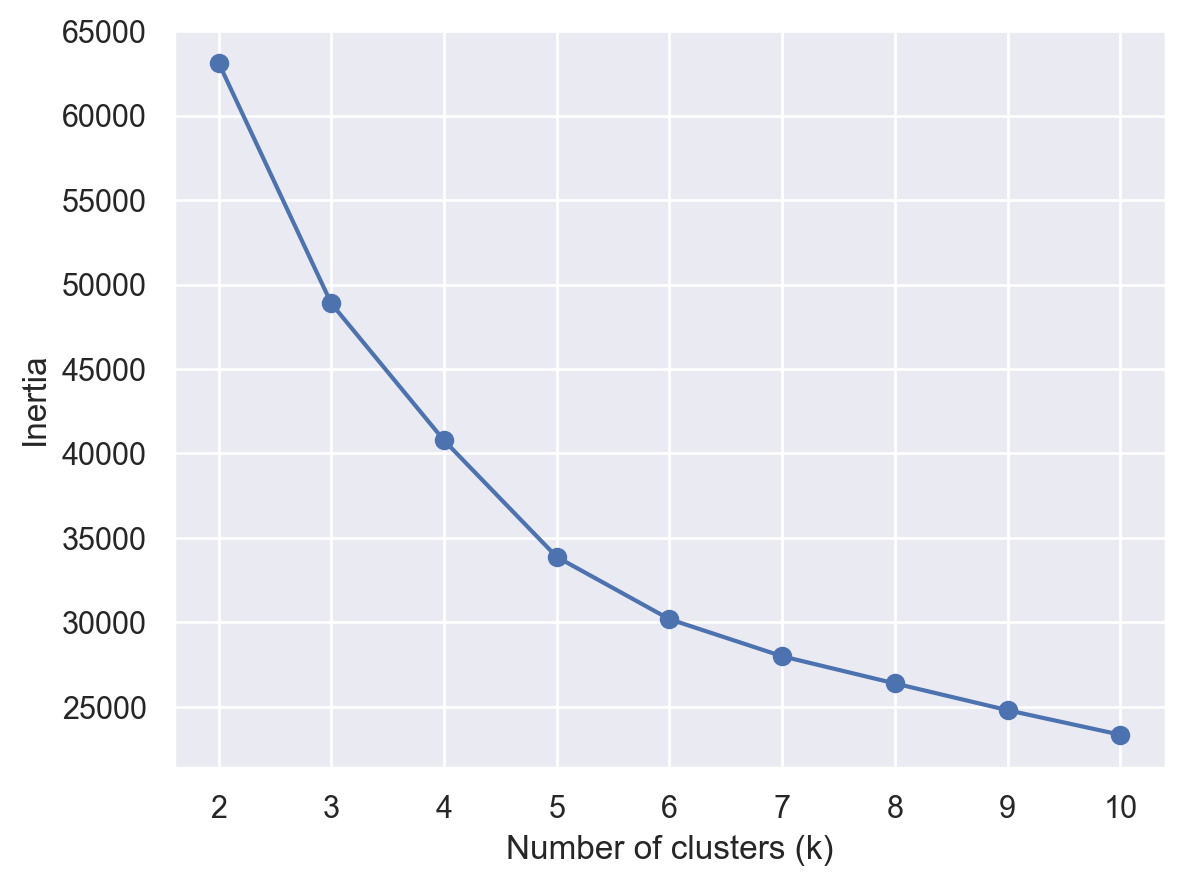

In [28]:
plt.plot(K, inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.show()

In [29]:
range_clusters = range(1, 7)

In [30]:
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(X2)  # fit the model to the data
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

For n_clusters = 2, the average silhouette_score is : 0.407816859176317
For n_clusters = 3, the average silhouette_score is : 0.4243623504791645
For n_clusters = 4, the average silhouette_score is : 0.42360941133940083
For n_clusters = 5, the average silhouette_score is : 0.3235305468489897
For n_clusters = 6, the average silhouette_score is : 0.29186547951105907


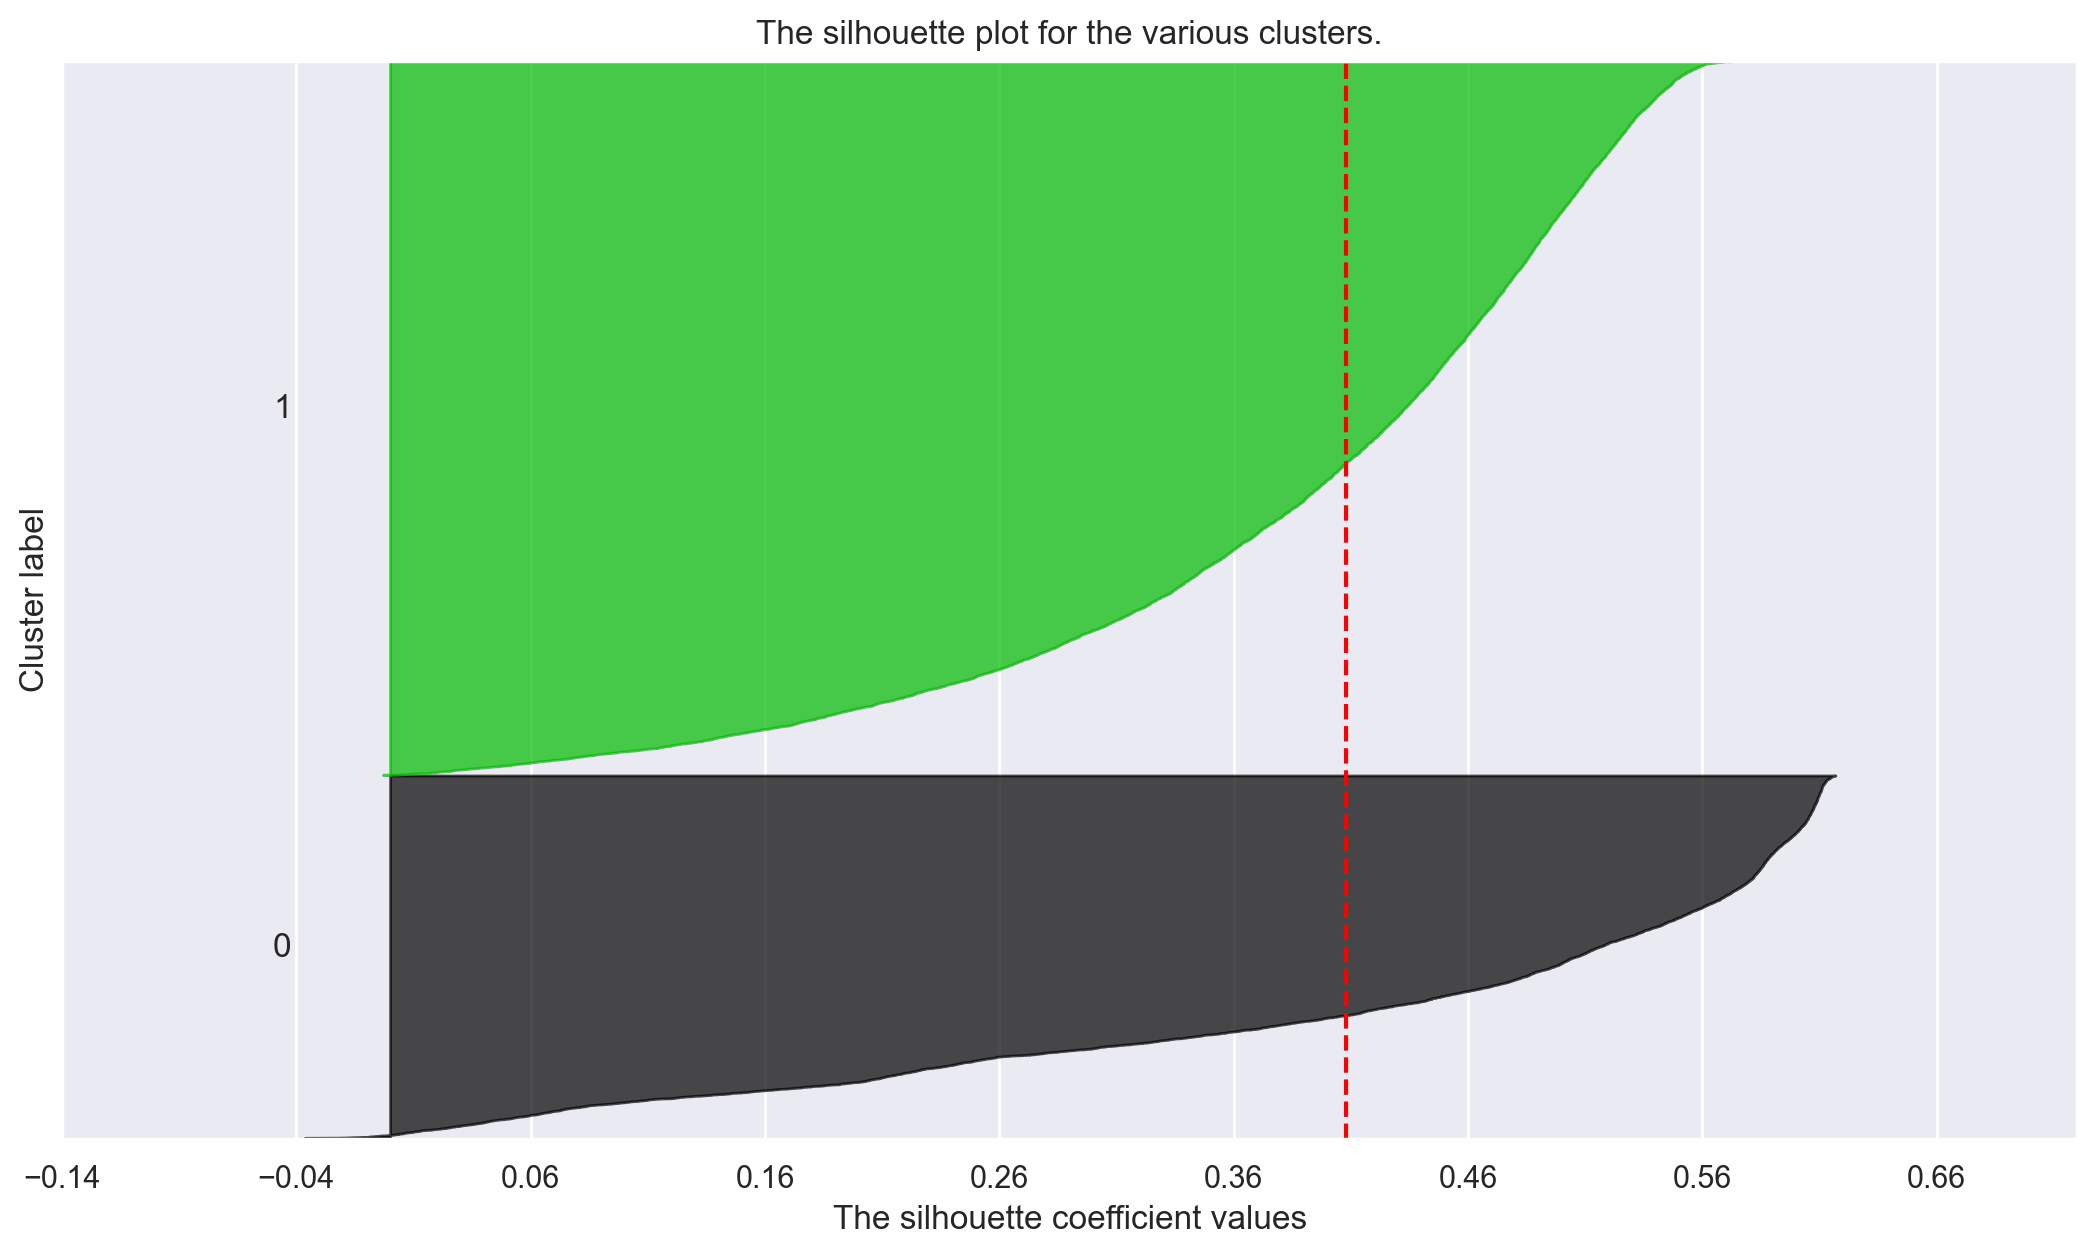

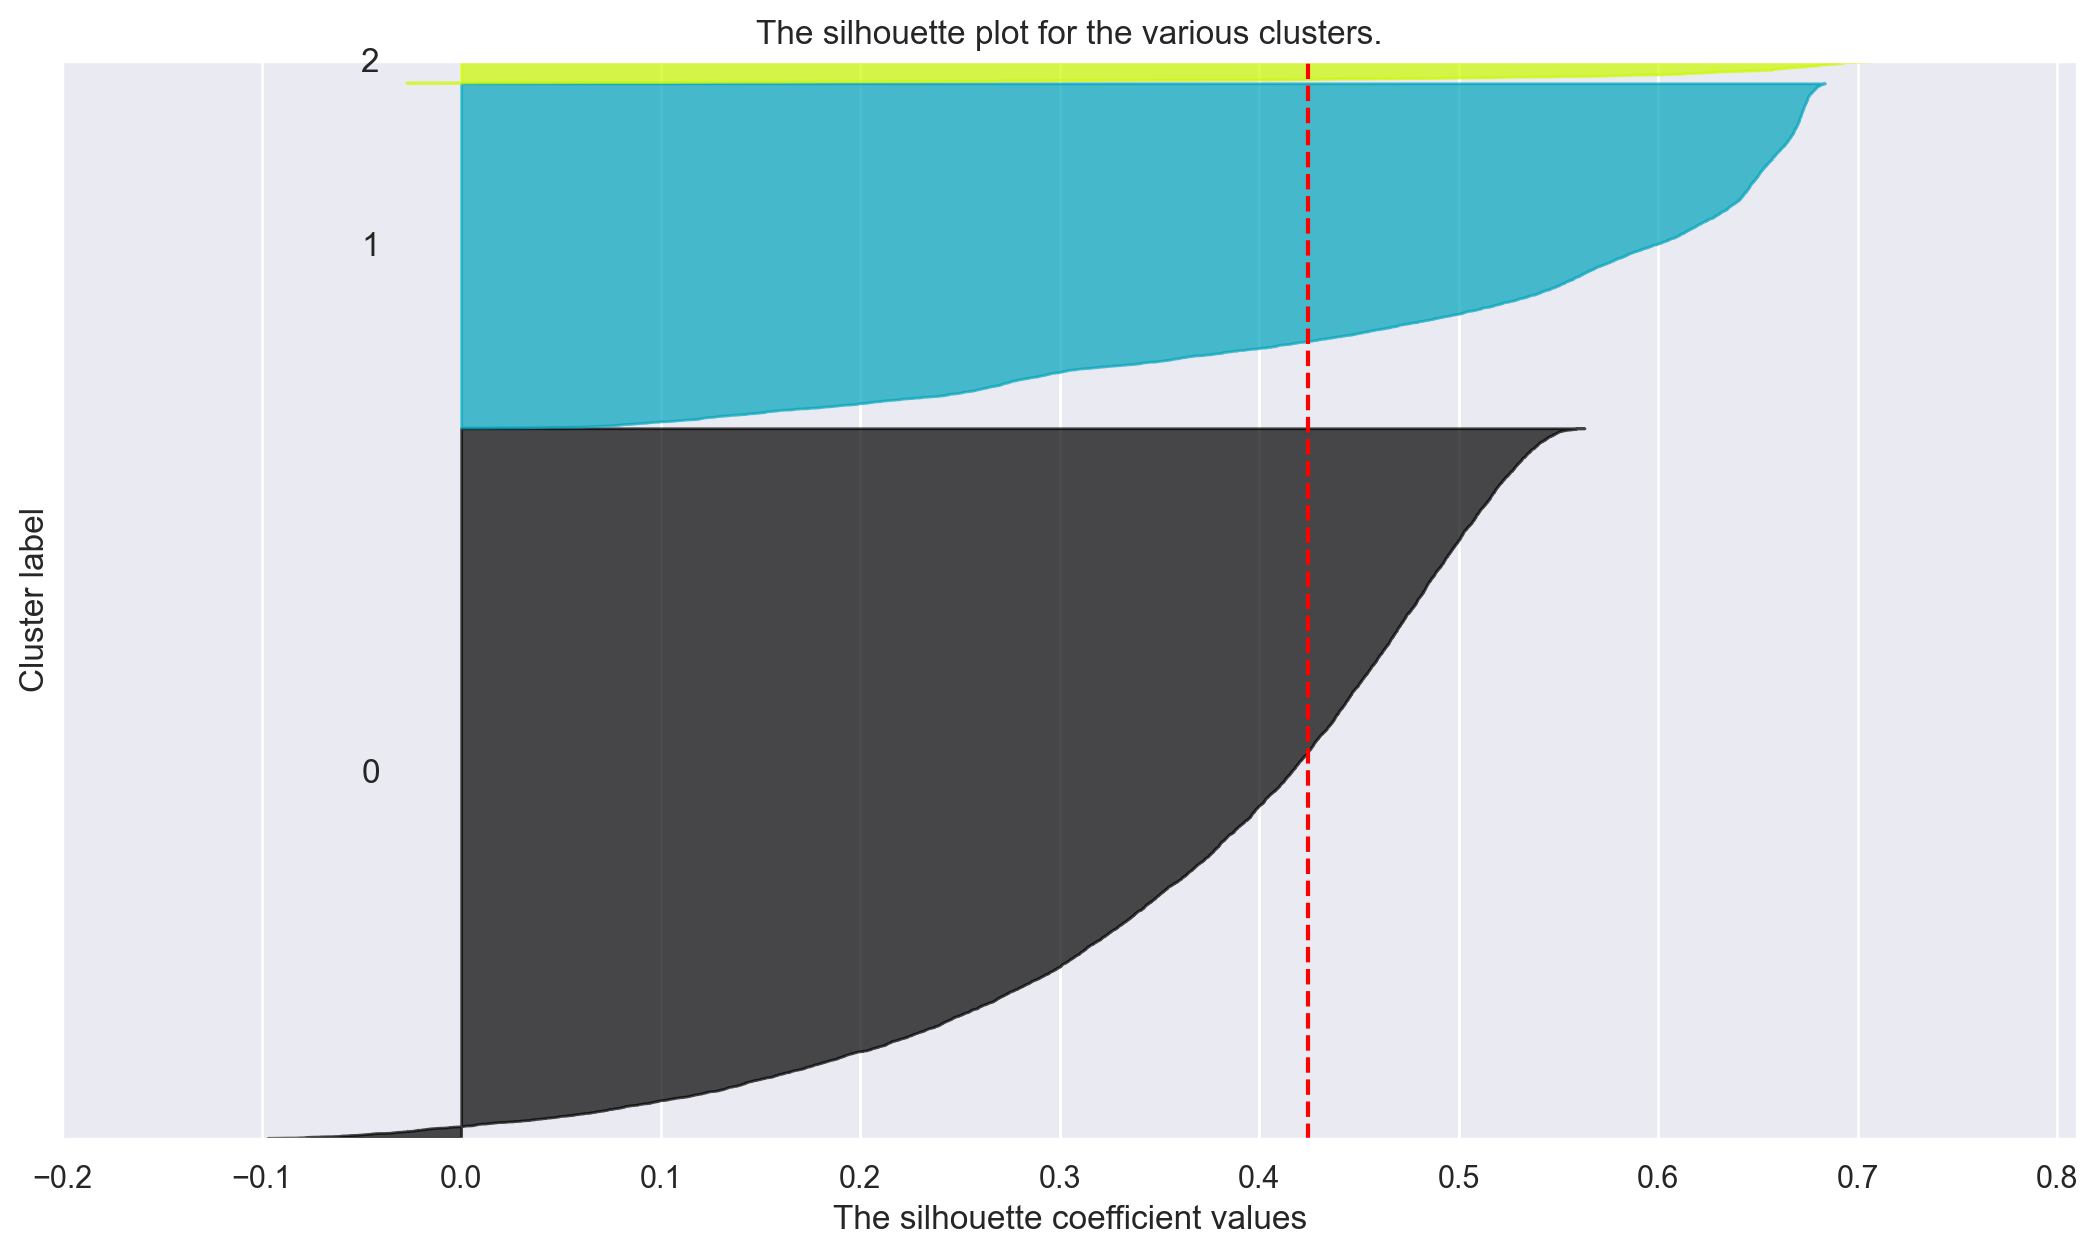

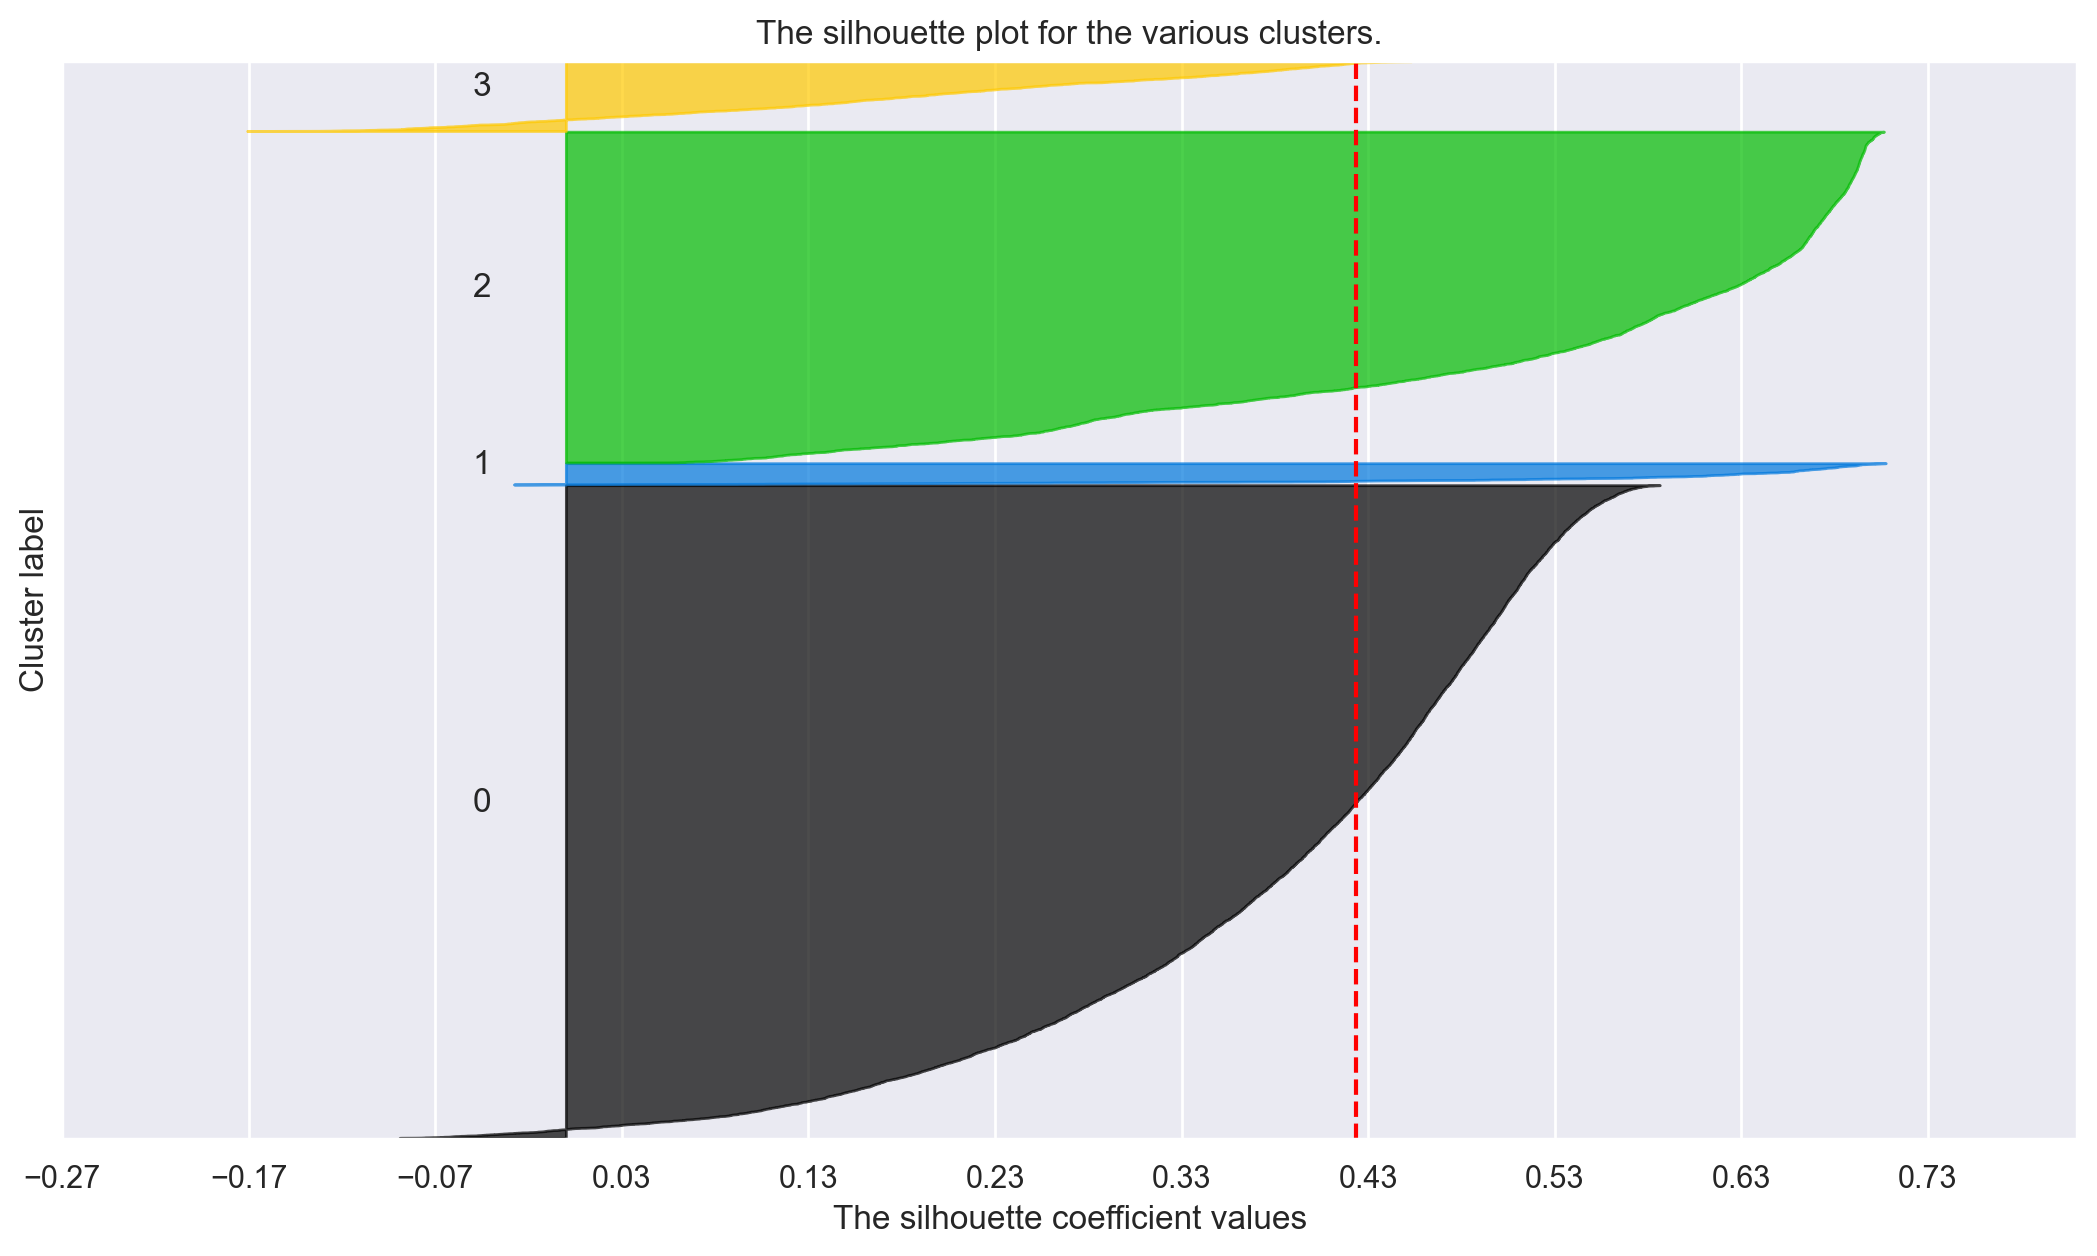

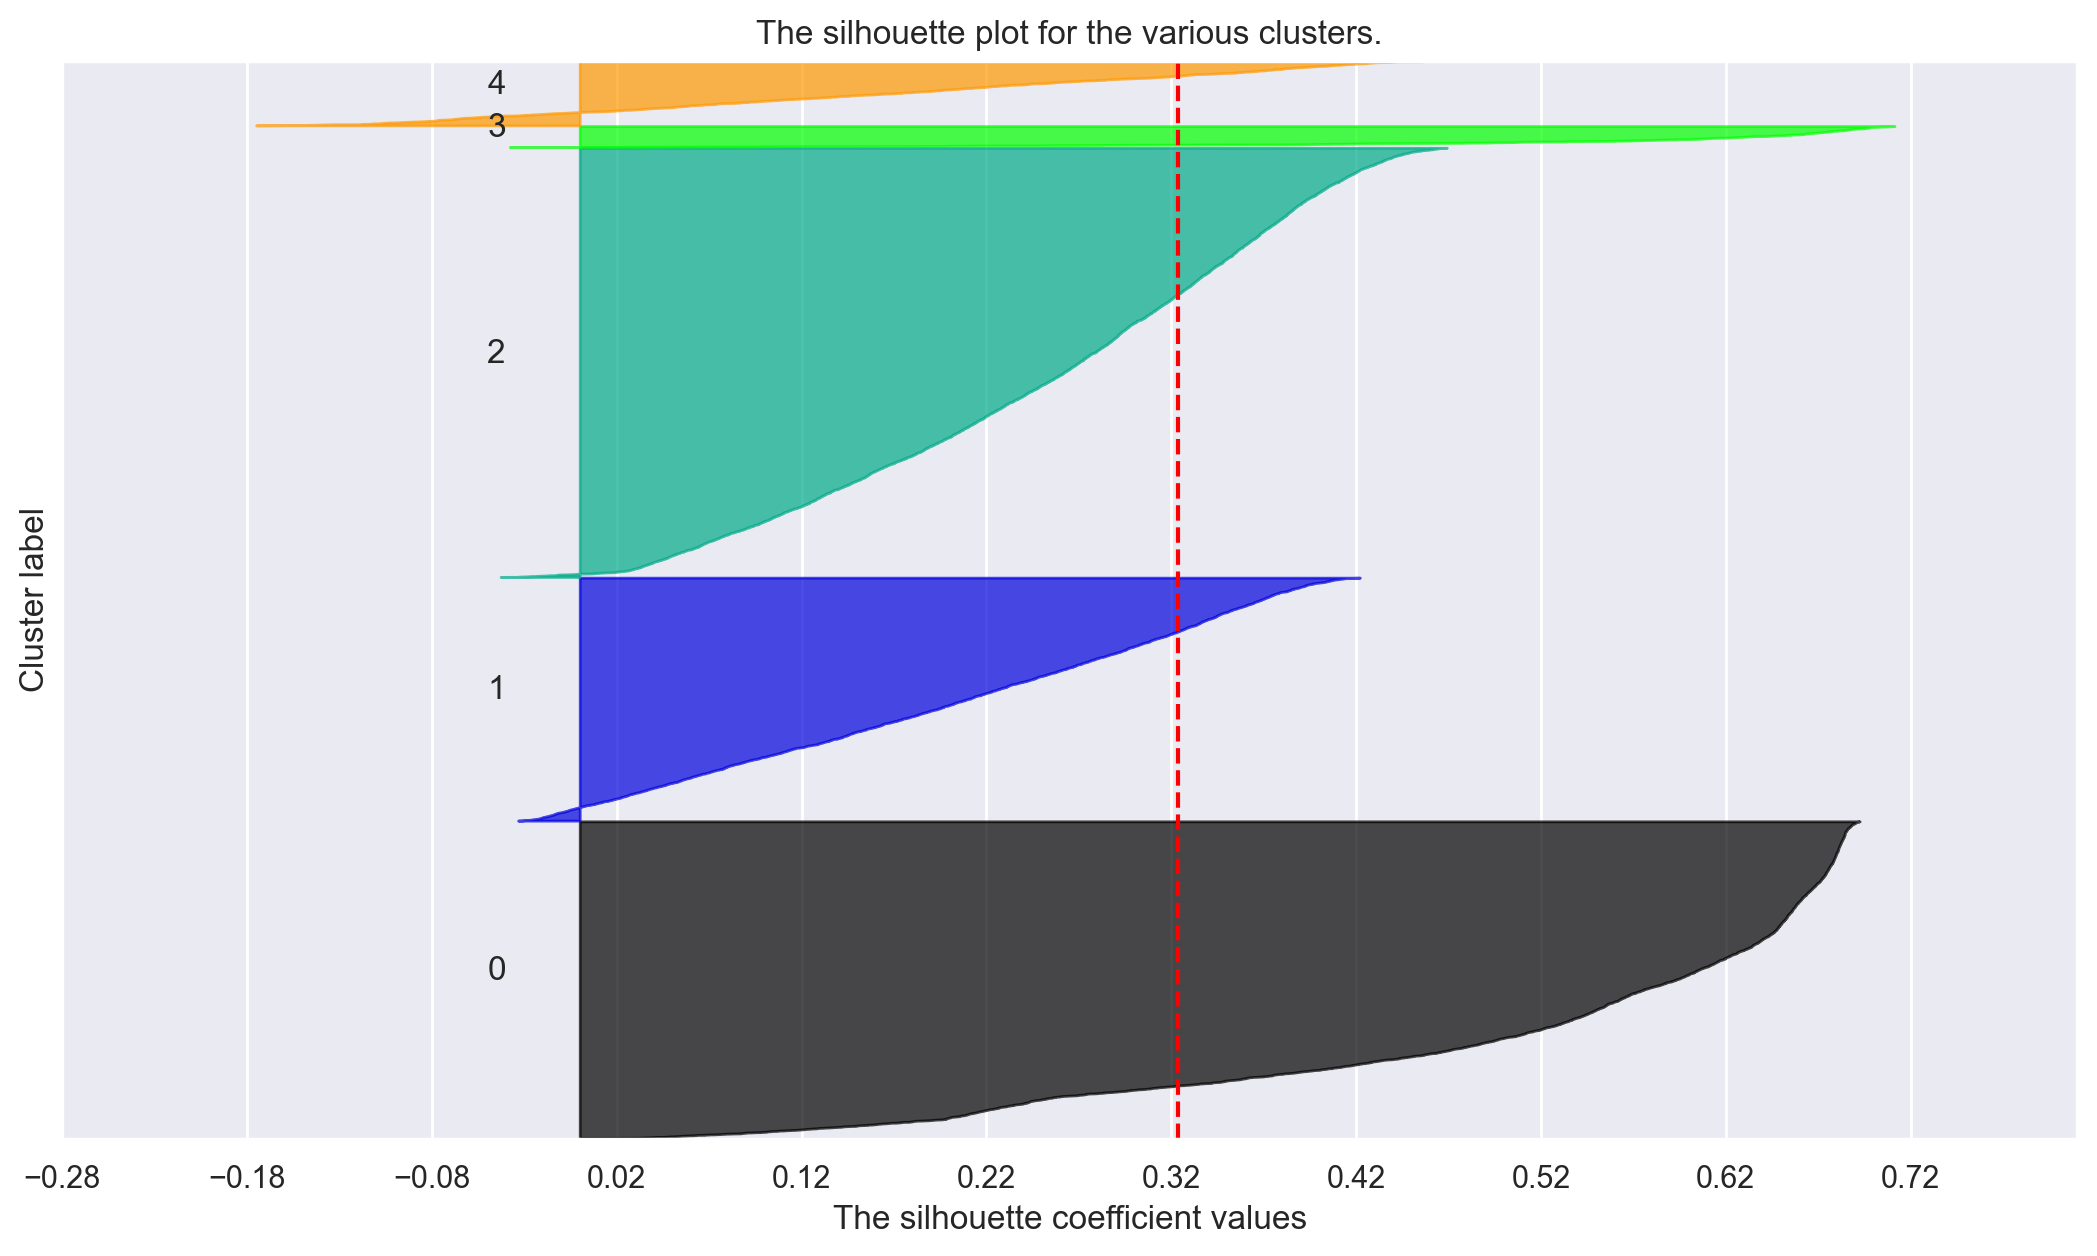

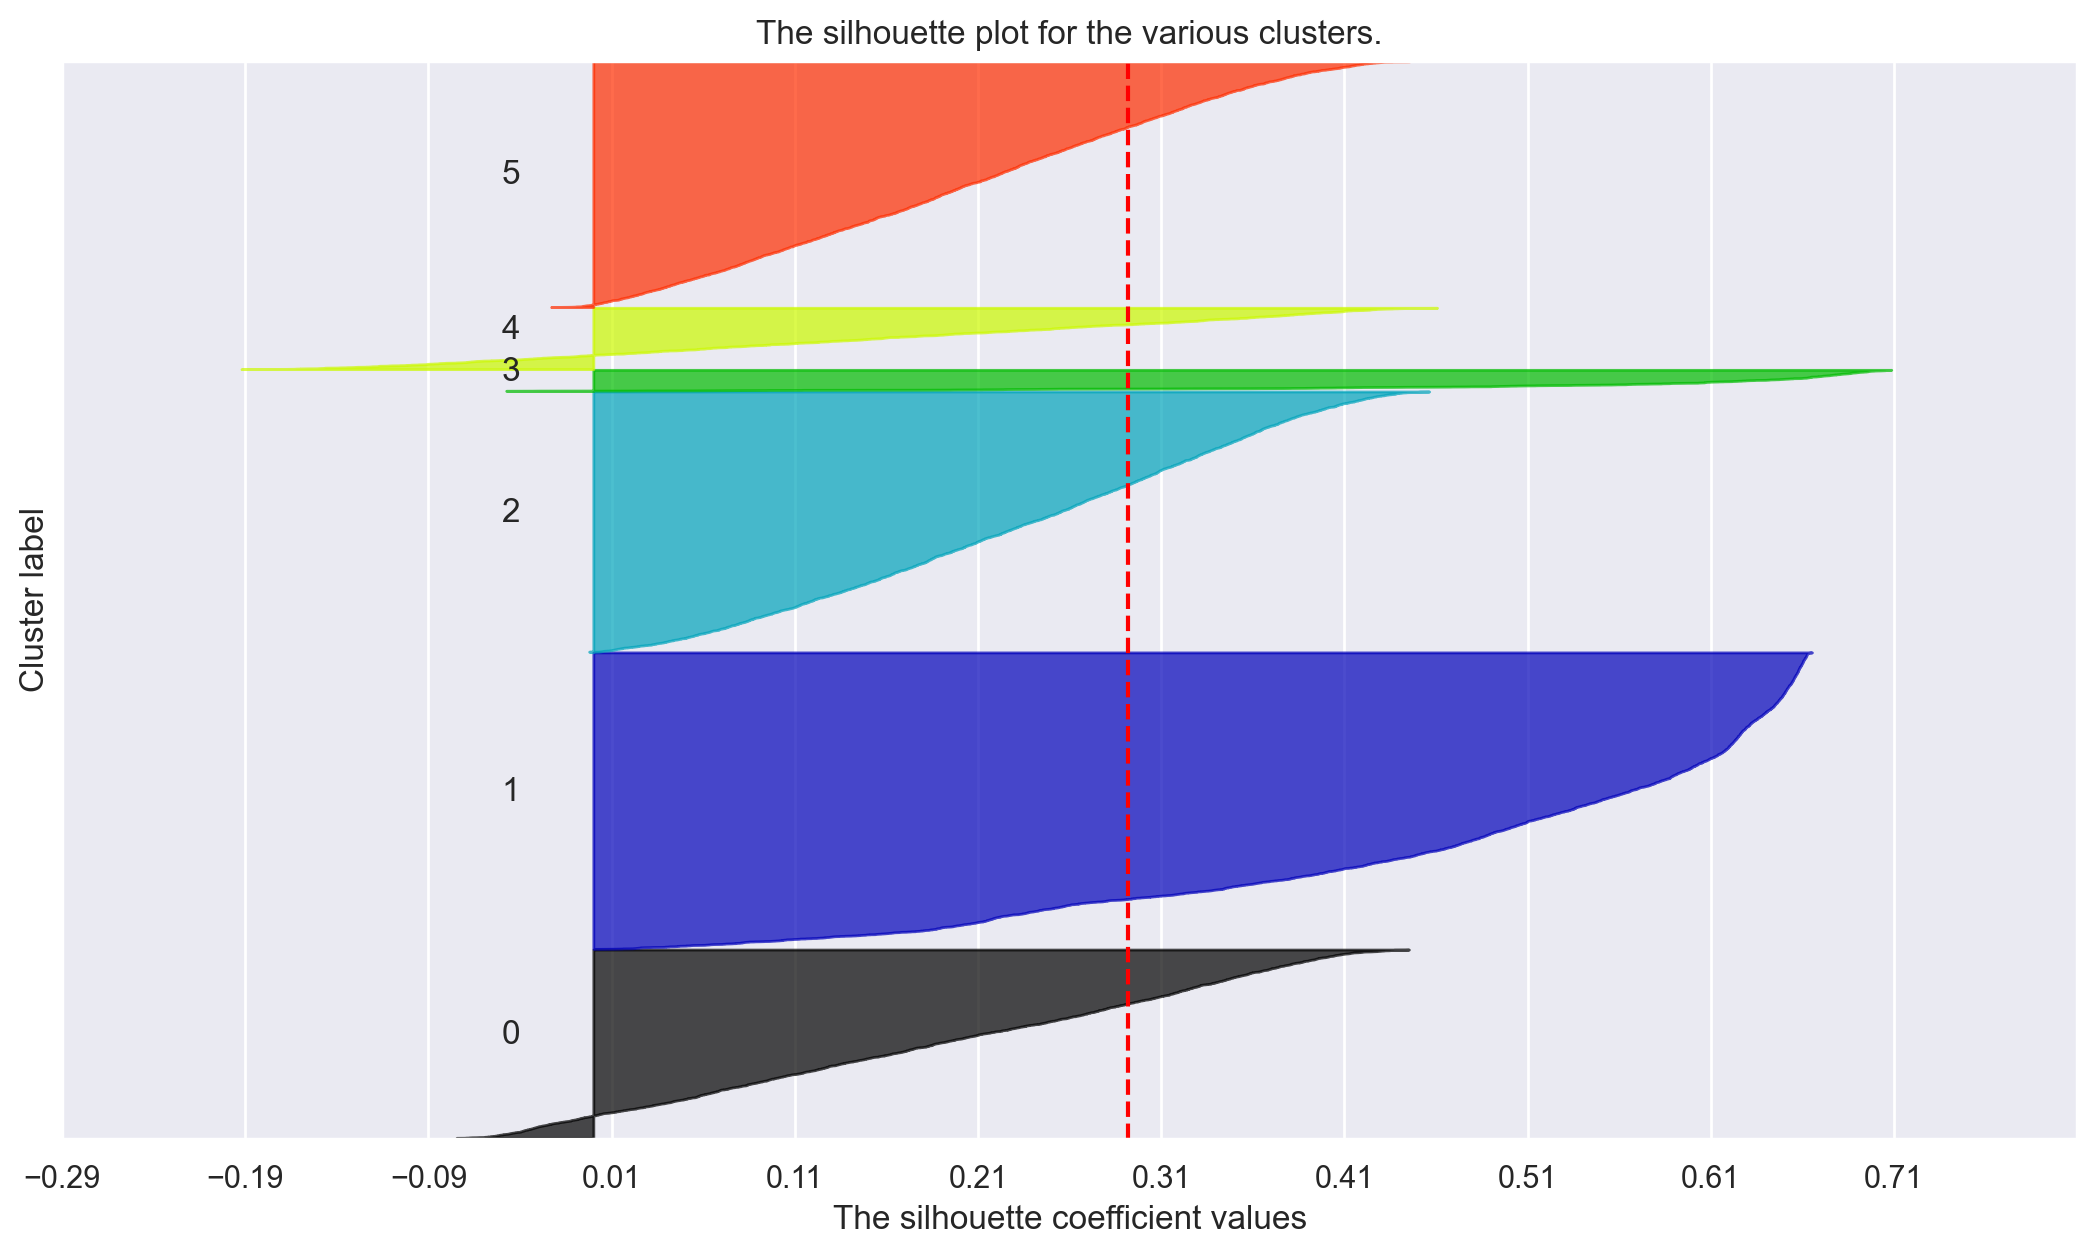

In [31]:
# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(X2)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X2, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X2, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(X2) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

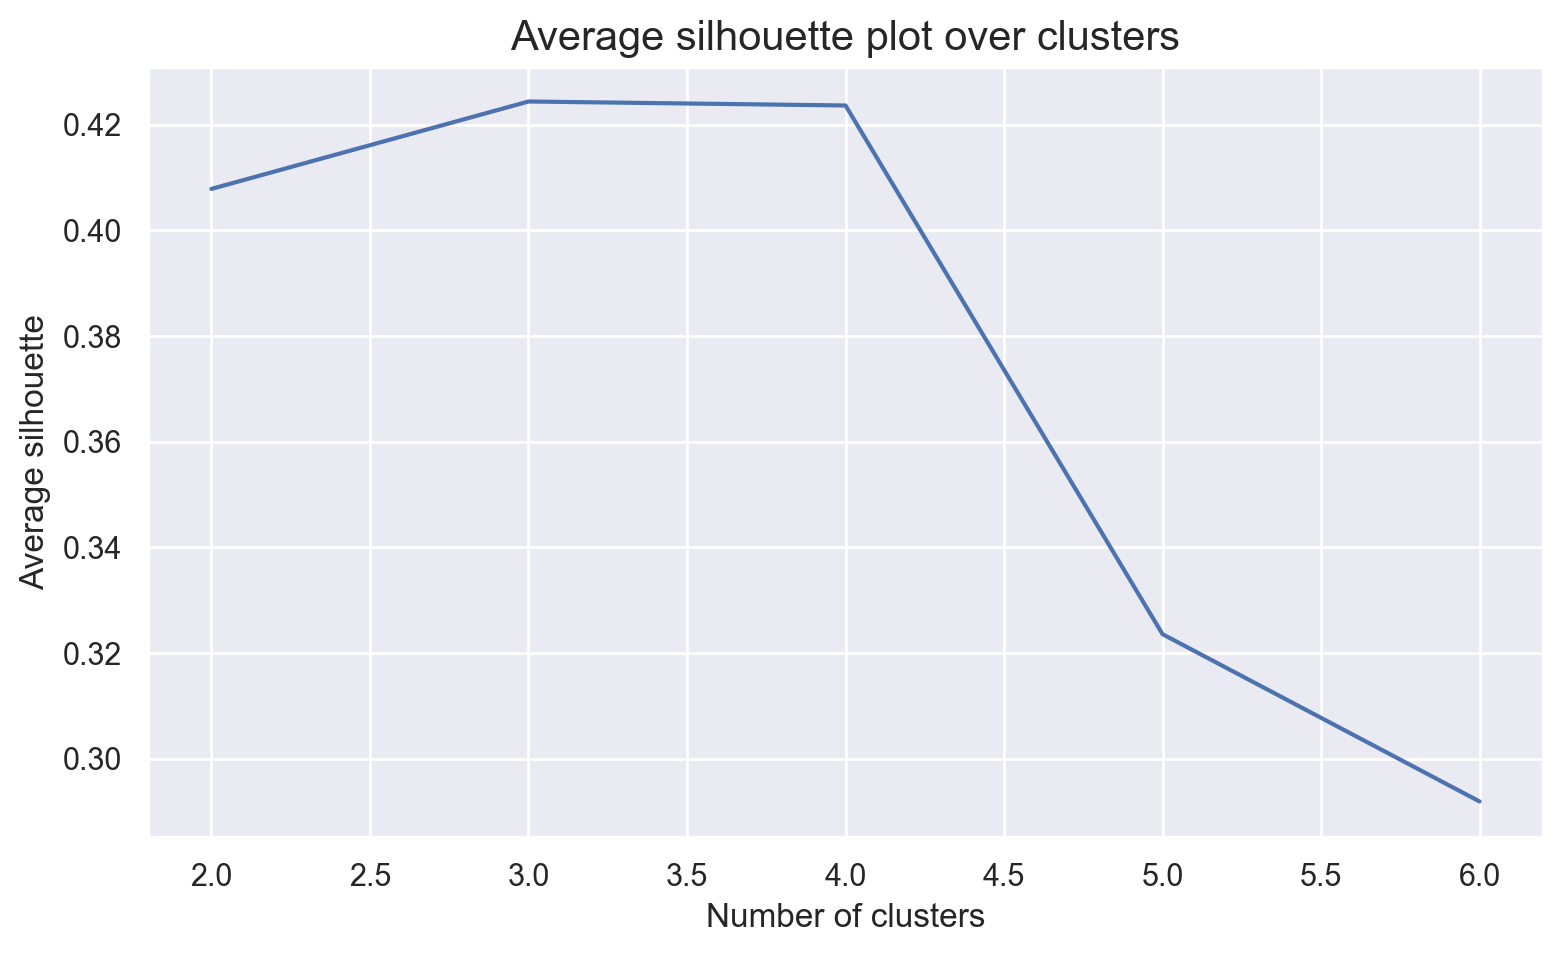

In [32]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))


#  Why range_clusters[1:] ? 
# Remember we skipped k=1 in the cell above

plt.plot(range_clusters[1:], ## Plot X-axis; 
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

Selection of the Optimal Number of Clusters

To determine the optimal number of clusters, the **elbow method** and the **average silhouette coefficient** were applied. The elbow method consists of plotting the within-cluster sum of squares (inertia) as a function of the number of clusters
k and identifying the point at which the rate of decrease in inertia slows down significantly, indicating diminishing returns from adding more clusters.

The average silhouette coefficient represents the mean of the silhouette values computed for all observations and provides a global measure of clustering quality. Higher values indicate better-defined and more compact clusters with greater separation. The silhouette coefficient ranges from **−1 to 1** and is commonly used to compare clustering solutions with different numbers of clusters.

From the analysis of the inertia curve, a substantial reduction in inertia is observed when increasing the number of clusters from \(k = 2\) to \(k = 3\) with additional but progressively smaller gains up to \(k = 4\).Beyond this point, the curve flattens noticeably, suggesting that adding more clusters leads to only marginal improvements in explaining within-cluster variance.

The average silhouette coefficient reaches its maximum value for \(k = 3\), indicating that this configuration provides the best balance between cluster cohesion and separation. While the silhouette values for \(k = 2\) and \(k = 4\) remain relatively high, they are slightly lower than for 
\(k = 3\), and a sharp decline is observed for solutions with \(k >= 5\), indicating over-segmentation and weaker cluster structure.

Although the 2-cluster solution offers a robust and highly aggregated partition, it risks oversimplifying the data by merging distinct behavioral patterns into a single group. Conversely, increasing the number of clusters beyond 3 results in reduced clustering quality, as reflected by both the flattening of the inertia curve and the decreasing silhouette scores.

Therefore, considering both statistical criteria and interpretability, the 3-cluster solution is selected as the optimal configuration. This choice achieves the highest silhouette score, lies at the elbow of the inertia curve, and provides a meaningful and interpretable segmentation without introducing unnecessary complexity.

In [33]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X2)



In [34]:
# Characterizing 3 clusters

df_concat = pd.concat([
    merged_df[metric_features], 
    pd.Series(kmeans_labels, name='labels', index=merged_df.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean().T

labels,0,1,2
NumFlights,102.525680,187.072872,40.415190
PointsAccumulated,20133.067160,38084.928123,8156.289208
PointsRedeemed,6518.285801,11657.592347,2155.363193
Recency_Months,14.232628,0.331261,0.010177
Customer Lifetime Value,7512.517100,7964.292804,8061.826208
CustomerTenure,752.154079,1440.015544,359.482661


### Density Clustering(DBSCAN)

In [35]:
X4 = X_num.copy()

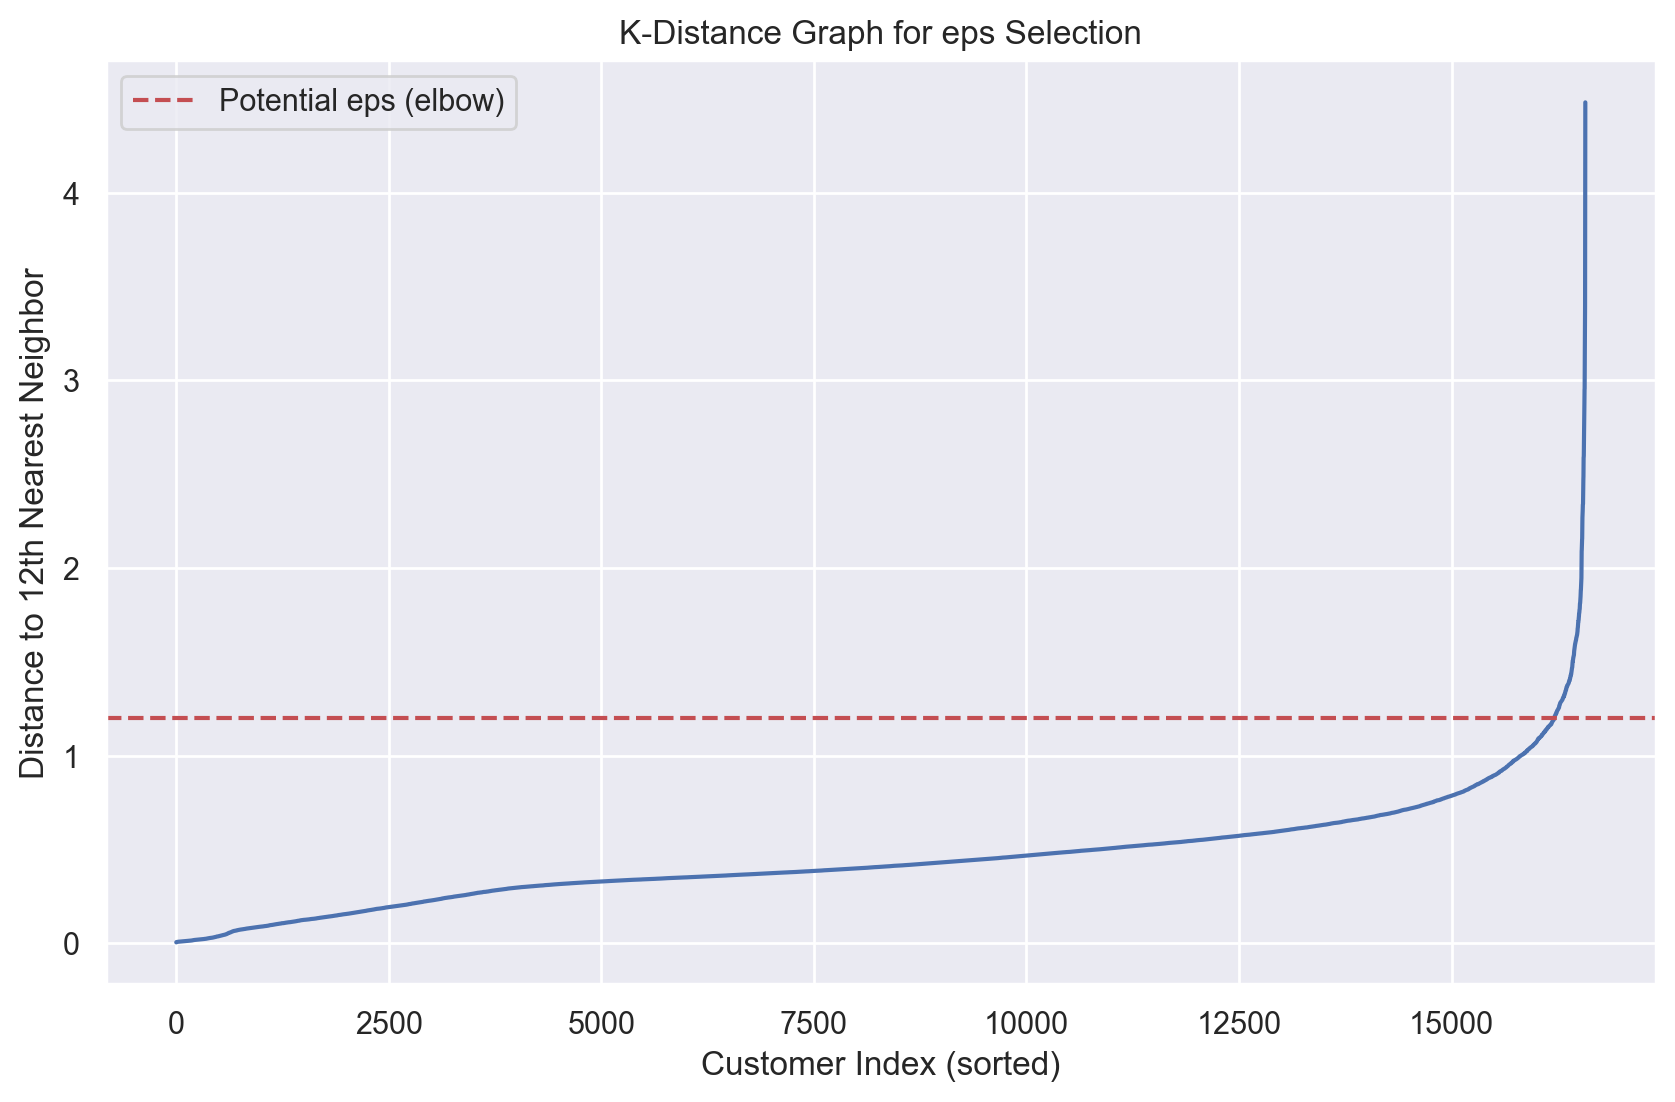

In [36]:
# Find optimal eps using K-distance method
neigh = NearestNeighbors(n_neighbors=12) # n_features * 2 as a rule of thumb
neigh.fit(X4)
distances, _ = neigh.kneighbors(X4)
# matrix of n_samples x n_neighbors nearest neighbors distances
distances = np.sort(distances[:, -1])
# distances for every sample to the 20th nearest neighbor, sorted


plt.figure(figsize=(10,6))
plt.plot(distances)
plt.title("K-Distance Graph for eps Selection")
plt.xlabel("Customer Index (sorted)")
plt.ylabel("Distance to 12th Nearest Neighbor")
plt.grid(True)

plt.axhline(y=1.2, color='r', linestyle='--', label='Potential eps (elbow)')

plt.legend()
plt.show()


This graph is used to determine an appropriate epsilon (`eps`) value for the DBSCAN clustering algorithm. It plots the distance to the 12th nearest neighbor for each data point (customer), sorted by index. The goal is to identify the "elbow point"—a sharp change in the slope of the curve—which indicates a suitable threshold for distinguishing dense clusters from sparse noise.

- **Y-axis**: Distance to the 12th nearest neighbor.
- **X-axis**: Sorted customer index.
- **Blue Line**: Represents the sorted distance values.
- **Red Dashed Line**: Marks the suggested `eps` value at the elbow point.

- The curve remains relatively flat for most of the data points, indicating consistent density.
- Toward the right end of the graph, there is a noticeable upward bend—this is the elbow point.
- The red dashed line intersects the curve at this inflection, suggesting a potential `eps` value that separates core points from outliers on **y = 1.2**.

The elbow method visually identifies a threshold where the density of points begins to drop significantly. Selecting an `eps` value at or slightly below the red dashed line will likely yield meaningful clusters while minimizing noise. This graph supports a data-driven approach to parameter tuning in DBSCAN.


In [37]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.2, min_samples=12, n_jobs=-1)

dbscan_labels = dbscan.fit_predict(X4)

In [38]:
np.unique(dbscan_labels)

array([-1,  0])

In [39]:
r2_db = get_rsq(merged_df, metric_features, dbscan_labels)
print(f"DBSCAN R² score: {r2_db:.4f}")

DBSCAN R² score: 0.0106


In [40]:
df_concat = pd.concat([
    merged_df[metric_features], 
    pd.Series(dbscan_labels, name='labels', index=merged_df.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean().T

labels,-1,0
NumFlights,138.640625,138.431777
PointsAccumulated,27838.253672,28147.444861
PointsRedeemed,13172.814844,8476.643372
Recency_Months,6.148438,0.462179
Customer Lifetime Value,30343.491094,7812.489150
CustomerTenure,1145.695312,1079.847927


<h1 style="background-color: Teal; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
Comparing different types of clusters
</h1>

In [41]:
merged_df['cluster'] = hc_labels
merged_df["Kmeans"] = kmeans_labels
merged_df["DBSCAN"] = dbscan_labels

In [42]:
cluster_comparison = pd.DataFrame({
    'Hierarchical': merged_df['cluster'], 'KMeans': merged_df['Kmeans'], 'DBSCAN': merged_df['DBSCAN']
})

In [43]:
cluster_comparison

,Hierarchical,KMeans,DBSCAN
Loyalty#,,,
100018,0,1,0
100102,0,1,0
100140,0,1,0
100214,0,1,0
100272,0,1,0
...,...,...,...
999902,0,1,0
999911,1,2,0
999940,1,2,0


In [44]:
pd.crosstab(
    pd.Series(hc_labels, name='hc_labels', index=merged_df.index),
    pd.Series(kmeans_labels, name='kmeans_labels', index=merged_df.index)
    )

kmeans_labels,0,1,2
hc_labels,,,
0,0,10463,422
1,0,346,4882
2,331,128,2


In [45]:
pd.crosstab(
    pd.Series(hc_labels, name='hc_labels', index=merged_df.index),
    pd.Series(dbscan_labels, name='dbscan_labels', index=merged_df.index)
    )

dbscan_labels,-1,0
hc_labels,,
0,65,10820
1,0,5228
2,63,398


In [46]:
pd.crosstab(
    pd.Series(kmeans_labels, name='kmeans_labels', index=merged_df.index),
    pd.Series(dbscan_labels, name='dbscan_labels', index=merged_df.index)
)

dbscan_labels,-1,0
kmeans_labels,,
0,55,276
1,53,10884
2,20,5286


<h1 style="background-color: Teal; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
Clustering by Perspectives
</h1>

In [47]:
behavioral_features = [
    'NumFlights',
    'NumFlightsWithCompanions',
    'FlightsWithCompanionsRatio',
    'PointsRedeemRatio'
]

value_features = [
    'Customer Lifetime Value',
    'PointsAccumulated',
    'PointsRedeemed'
]

df_behavior = merged_df[behavioral_features].copy()
df_value = merged_df[value_features].copy()

In [48]:
# Important: need to valudate K!
kmeans_behavior = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=1)
merged_df['behavioral_labels_kmeans'] = kmeans_behavior.fit_predict(merged_df[behavioral_features])


# Important: need to valudate K!
kmeans_value = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=1)
merged_df['value_labels_kmeans'] = kmeans_value.fit_predict(merged_df[value_features])


In [49]:
label_cols = ['behavioral_labels_kmeans', 'value_labels_kmeans']

merged_df[label_cols]

,behavioral_labels_kmeans,value_labels_kmeans
Loyalty#,,
100018,1,2
100102,1,2
100140,1,0
100214,2,0
100272,1,2
...,...,...
999902,1,2
999911,0,1
999940,0,0


In [50]:
pd.crosstab(
    pd.Series(merged_df['behavioral_labels_kmeans'], name='behavior', index=merged_df.index),
    pd.Series(merged_df['value_labels_kmeans'], name='value', index=merged_df.index),)

value,0,1,2
behavior,,,
0,156,4568,9
1,2938,6,3072
2,3918,462,1445


In [51]:

kmeans_behavior = AgglomerativeClustering(n_clusters=3, linkage='ward', metric='euclidean')
merged_df['behavioral_labels_hierarchical'] = kmeans_behavior.fit_predict(merged_df[behavioral_features])


# Important: need to valudate K!
kmeans_value = AgglomerativeClustering(n_clusters=3, linkage='ward', metric='euclidean')
merged_df['value_labels_hierarchical'] = kmeans_value.fit_predict(merged_df[value_features])

In [52]:
label_cols = ['behavioral_labels_hierarchical', 'value_labels_hierarchical']

merged_df[label_cols]

,behavioral_labels_hierarchical,value_labels_hierarchical
Loyalty#,,
100018,2,0
100102,2,0
100140,2,0
100214,1,0
100272,1,0
...,...,...
999902,2,0
999911,0,1
999940,0,0


In [53]:
pd.crosstab(
    pd.Series(merged_df['behavioral_labels_hierarchical'], name='behavior', index=merged_df.index),
    pd.Series(merged_df['value_labels_hierarchical'], name='value', index=merged_df.index),)

value,0,1,2
behavior,,,
0,180,4100,897
1,5007,26,2109
2,3909,0,346


  
## Behavioral and Value-Based Clustering Perspectives

### 1. Most Interpretable and Stable Clustering Method

Both **K-Means** and **Agglomerative Clustering** were applied to the behavioral and value-based feature sets.  
K-Means produced **more interpretable and stable** clusters, with clearer separation and more balanced distributions in the contingency tables.  
Hierarchical clustering offered structural insight but showed **less consistency** across perspectives.

**Conclusion:** K-Means is the most reliable method for both perspectives.


### 2. Optimal Number of Clusters

A solution with **three clusters per perspective** was selected.  
This choice was supported by:

- Distinct patterns in the cross-tabulations  
- Clear behavioral and value differentiation  
- Avoidance of over-fragmentation while maintaining meaningful granularity  

**Conclusion:** Three clusters adequately represent the diversity of the customer base.


### 3. Key Differentiating Features

### Behavioral Perspective
- Number of flights  
- Flights with companions  
- Points redemption ratio  

### Value Perspective
- Customer lifetime value  
- Points accumulated  
- Points redeemed  

These perspectives **complement each other** by combining usage behavior with financial contribution, enabling a more complete understanding of customer engagement and profitability.


### 4. Business Interpretation of Customer Segments

The combined segmentation results in **nine possible customer profiles** (3 behavioral × 3 value clusters). Examples include:

- **High behavior / high value:** Frequent and profitable customers suited for premium loyalty initiatives.  
- **High behavior / low value:** Active but low-return customers, ideal for upsell or engagement campaigns.  
- **Low behavior / high value:** Infrequent but financially valuable customers requiring retention-focused strategies.

### Marketing Opportunities
- Personalized offers based on behavioral and value patterns  
- Targeted retention for high-value groups  
- Engagement incentives for low-activity customers  
